## 1. Introdução

<div>
<img src="5361.webp" width="600"/>
</div>
<center> (Photo by: Vlad Deep/Alamy) </center> 

No processo de fabricação de produtos semicondutores, muitas etapas de produção são necessárias, envolvendo o uso de diferentes máquinas. É difícil eliminar ou identificar disfunções em cada etapa do tratamento. As condições de operação em um ambiente de controle de processo podem frequentemente mudar, intencionalmente ou não. É por isso que a identificação de KPIVs (Key Process Input Variables) é essencial para permitir uma rápida recuperação, otimização e controle. O objetivo deste estudo de caso é desenvolver uma abordagem de seleção de características causais que se aplique a este domínio, ajude a resolver problemas de controle de processos e a aprimorar estratégias gerais de melhoria de negócios.

Para isso, vamos usar o UCI SECOM Dataset. O primeiro arquivo contém 1567 exemplos, cada um com 591 feições, formando assim uma matriz de dimensões 1567 x 591. O segundo arquivo é um arquivo de etiquetas que contém as classificações e timestamps correspondentes a cada exemplo. Como em todas as situações de dados reais, esses dados podem conter valores nulos que variam em intensidade com base nas características individuais. Não apenas isso, mas o conjunto de dados também é desequilibrado, pois contém apenas 104 falhas (6,6% exemplos).

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from feature_engine.selection import RecursiveFeatureElimination
from feature_engine.selection import DropConstantFeatures, SmartCorrelatedSelection
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.metrics import precision_recall_curve, roc_curve 
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import ConfusionMatrixDisplay
from time import perf_counter

Primeiramente, importamos os dados e os embaralhamos para que não haja nenhum viés quanto a sua organização.

In [8]:
X = pd.read_csv('secom.data',delim_whitespace=True, header=None)
y = pd.read_csv('secom_labels.data',delim_whitespace=True, header=None)[0]

y = y.replace({-1: 0})

seed = 101

kf = StratifiedKFold(4, shuffle = True, random_state = seed)

In [9]:
X = X.sample(frac=1, random_state = seed)
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = seed)

X_copy = X_train.copy()
n = len(X_copy)
n_sqrt = int(n ** 0.5)

Nosso modelo selecionado é a regressão logística com imputação KNN para lidar com valores ausentes. Como diretriz geral, determinamos o número de vizinhos como a raiz quadrada do número total de instâncias, selecionamos a regularização L2 com C igual a 100 e garantimos que os pesos das classes sejam equilibrados. Testaremos diferentes hiperparâmetros depois de selecionarmos os recursos mais importantes. O conjunto de dados deve ser escalado, pois o KNN é um algoritmo baseado em distância.

In [10]:
pipe_lr = Pipeline(steps = [
    ('scaler', MinMaxScaler()),
    ('imputer', KNNImputer(n_neighbors = n_sqrt)),
    ('estimator', LogisticRegression(penalty = 'l2', 
                                     solver = 'liblinear', 
                                     max_iter = int(1e5),
                                     C = 1e3,
                                     class_weight = 'balanced'))
])

records = {'cv_ap_score': [],
           'training_time': [],
           'procedure': []}

Devemos reportar cada melhoria em nosso modelo a medida que efetuamos seleção de features. Para isso, desenvolveremos uma função para facilitar o registro de novas informações. Para o nosso problema, escolheu-se a precisão média (average precision), que é uma métrica independente do threshold, além de mais de ser mais apropriado para datasets desbalanceados.  

In [11]:
def info_resume(X, procedure = 'Nothing', record = None):
    
    if record is None:
        record = {'cv_ap_score': [],
           'training_time': [],
           'procedure': []}
        
    
    num_feats = len(X_copy.columns)
    
    rec = dict()
    record_copy = record.copy()
    
    times = []
    
    for i in range(10):
        start = perf_counter()
        pipe_lr.fit(X, y_train)
        end = perf_counter()
        times.append(end-start)
        
    
    cv_mean = cross_val_score(pipe_lr, X, y_train, cv = kf, scoring = 'average_precision').mean()
    
    rec['cv_ap_score'] = cv_mean
    rec['training_time'] = (np.mean(times))
    rec['procedure'] = f'{procedure} ({num_feats})'
    
    fig, ax = plt.subplots(1, 2, figsize = (12, 5))
    
    fig.suptitle(f'CV AP Score: {cv_mean:.3f}, Tempo de Treino: {(end-start):.3f} segundos, Procedimento: {procedure}')
    ax[0].set_title(f'Dados Faltantes:   {X_copy.isnull().sum().sum() / (n * len(X_copy.columns)) * 100:.2f} %')
    sns.heatmap(X.isnull(), ax = ax[0]);
    ax[1].set_title(f'Número de Colunas: {num_feats:3d}')
    sns.heatmap(X.corr(), ax = ax[1]);
    fig.tight_layout()

    for k, v in rec.items():
        record_copy[k].append(v)
    
    return record_copy

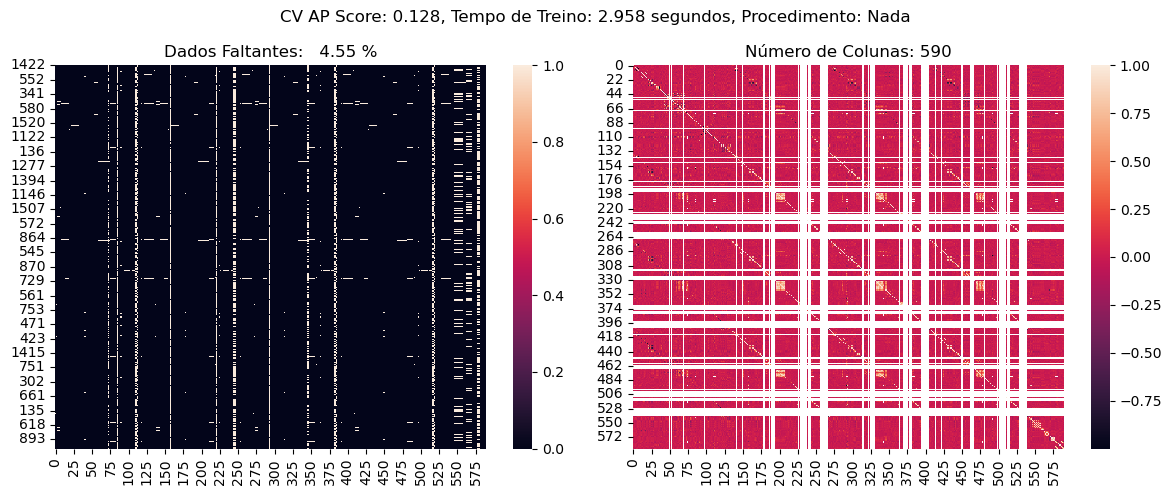

In [12]:
records = info_resume(X_copy, 'Nada', records)

A uma quantidade considerável de dados faltantes, observando-se colunas inteiras quase que completamente não registradas. A precisão média da Validação Cruzada deu em torno de 0,128, o que já é mais que o dobro que um classificador aleatório, o que classificaria considerando apenas assumindo a proporção dos dados (0,06). Note que há espaçamento  na matriz de correlação. Isso ocorre quando uma feature não possui variância, em outras palavras, quando ela é constante.

## 2. Seleção de Features Não Supervisionada

Nesta seção, apresentamos abordagens de seleção de recursos que são independentes do alvo, portanto, não supervisionados.

### 2.1. Eliminar Features Constantes

Features constantes não trazem nenhuma informação nova, uma vez que, sendo um valor constante, não muda nem um pouco quando a classe muda.

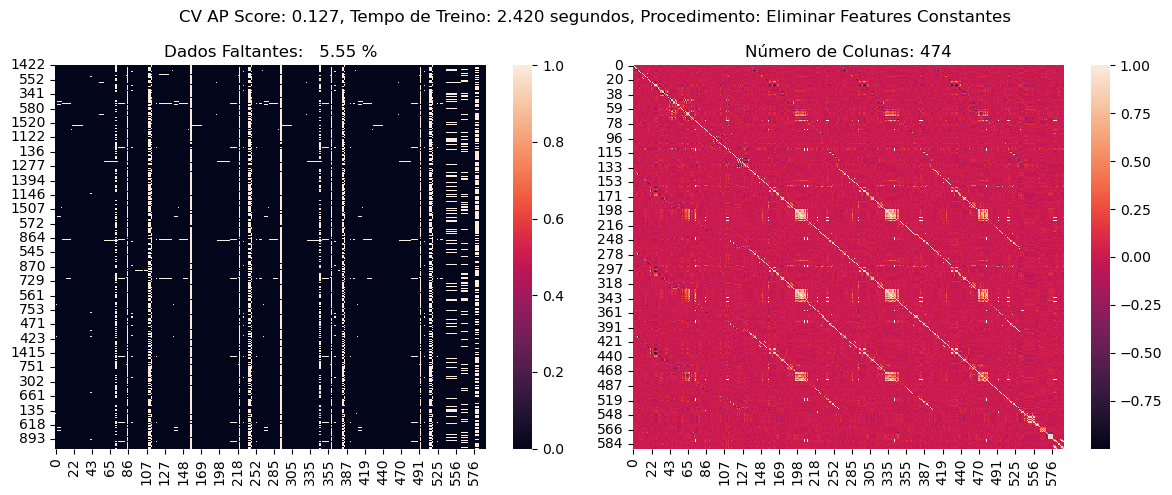

In [13]:
X_copy = DropConstantFeatures(missing_values='ignore').fit_transform(X_copy)

records = info_resume(X_copy, 'Eliminar Features Constantes', records)

Não houve uma melhora significativa na precisão, mas teve no Tempo de Treinamento, diminuindo-o consideravelmente.

### 2.2. Eliminar Features Correlacionadas

Quando uma feature está correlacionada com outra, indica que podem fornecer informações semelhantes ou explicar o mesmo fenômeno. Como resultado, manter os dois recursos pode levar à redundância. No entanto, ao decidir qual feature descartar, podemos fazê-lo de maneira ponderada. Para isso, já que o banco de dados sofre de dados faltantes, vamos usar este critério: a feature que tem mais dados faltantes é descartada. 

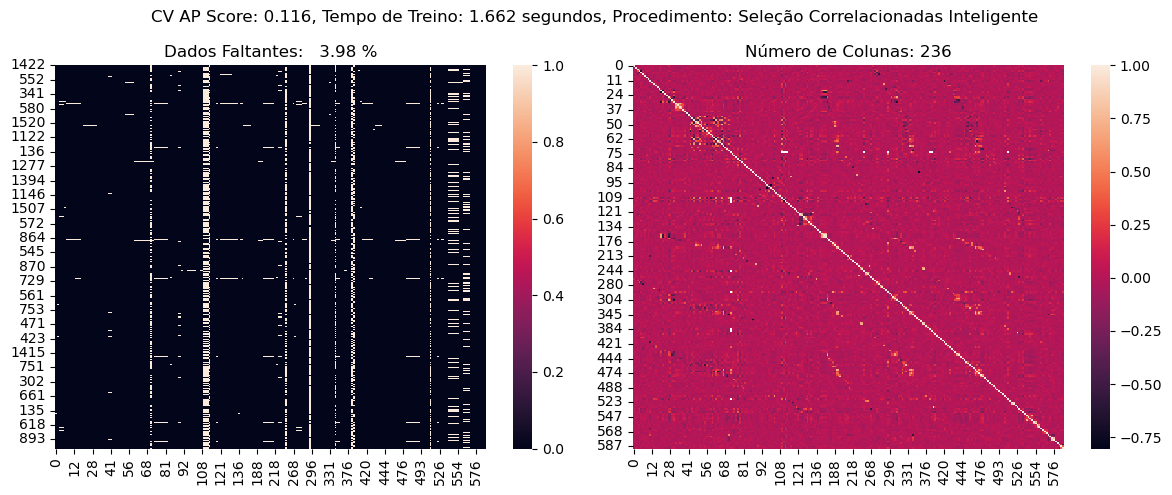

In [14]:
X_copy = SmartCorrelatedSelection(threshold=0.8, selection_method='missing_values').fit_transform(X_copy)

records = info_resume(X_copy, 'Seleção Correlacionadas Inteligente', records)

Há uma leve redução no desempenho, mas há também uma redução do tempo de treinamento pela metade.

### 2.3. Eliminar Features com mais Dados Faltantes

Features com muitos valores ausentes podem não ser importantes para a realização da tarefa. Com isso, descartá-las pode ser uma boa estratégia na seleção de features.

In [15]:
miss_series = X_copy.isnull().sum() / len(X_copy)

miss_series.sort_values(ascending = False).head(22) 

292    0.910615
384    0.646449
109    0.646449
244    0.646449
110    0.646449
111    0.646449
517    0.646449
72     0.512370
345    0.512370
112    0.458899
385    0.458899
569    0.173184
568    0.173184
563    0.173184
562    0.173184
546    0.168396
547    0.168396
548    0.168396
552    0.168396
553    0.168396
554    0.168396
224    0.032721
dtype: float64

Eliminando features com mais de 10% de dados ausentes.

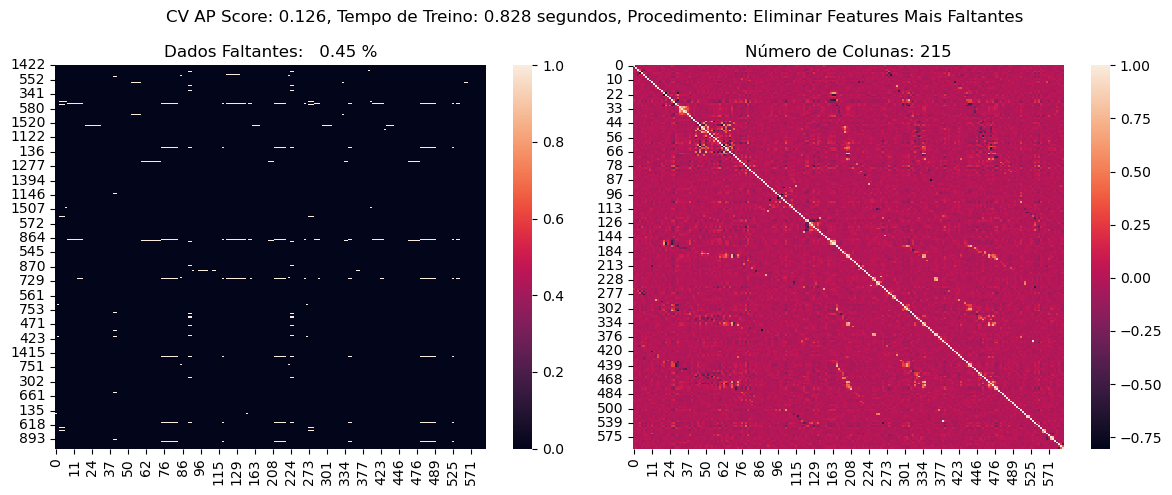

In [16]:
drop_miss = miss_series.loc[miss_series > 0.10]

X_copy = X_copy.drop(drop_miss.index, axis = 1)

records = info_resume(X_copy, 'Eliminar Features Mais Faltantes', records)

Houve um leve aumento na performance e uma drástica queda no tempo de treino, mesmo que tenha sido poucas features eliminadas. Isso provavelmente deve estar relacionado o processo de imputação. Quanto menos valores a serem imputados, mais rápido o processo ocorrerá.

## 3. Seleção Supervionada de Features

Agora, aplicaremos abordagens que utilizam informações da variável alvo, portanto, supervisionadas.

### 3.1. Eliminar Menos Correlacionadas com o Alvo

O problema que temos em questão é de classificação binária, portanto, caso uma feature apresente uma correlação linear forte com o alvo, esta feature pode contém informação valiosa capaz de distinguir as duas classes. Caso seja muito fraca, pode ser apenas uma feature ruidosa. Vamos olhar a distribuição de correlações com o alvo.

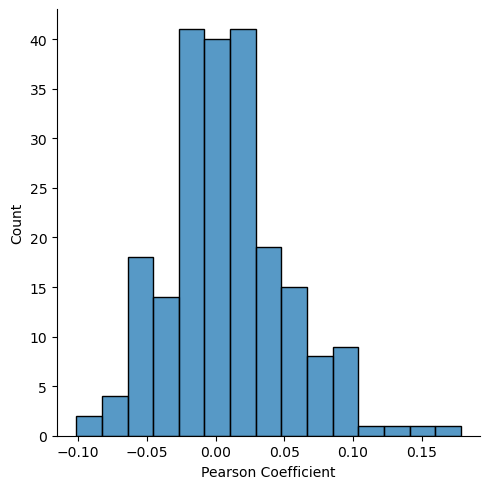

In [17]:
df = pd.concat([X_copy, y], axis = 1)
series = df.corr().iloc[:-1, -1]
series.name = 'Pearson Coefficient'

sns.displot(series, bins = 15);

Para seleção de features, descartamos features com correlações abaixo de 0,025. É importante considerar as correlações positivas e negativas para a distinção de classe.

In [18]:
def pearson_drop(X, y, threshold):
    df = pd.concat([X, y], axis = 1)
    series = df.corr().iloc[:-1, -1]
    series = series.loc[np.abs(series) > threshold] 
    return X.loc[:, series.index]

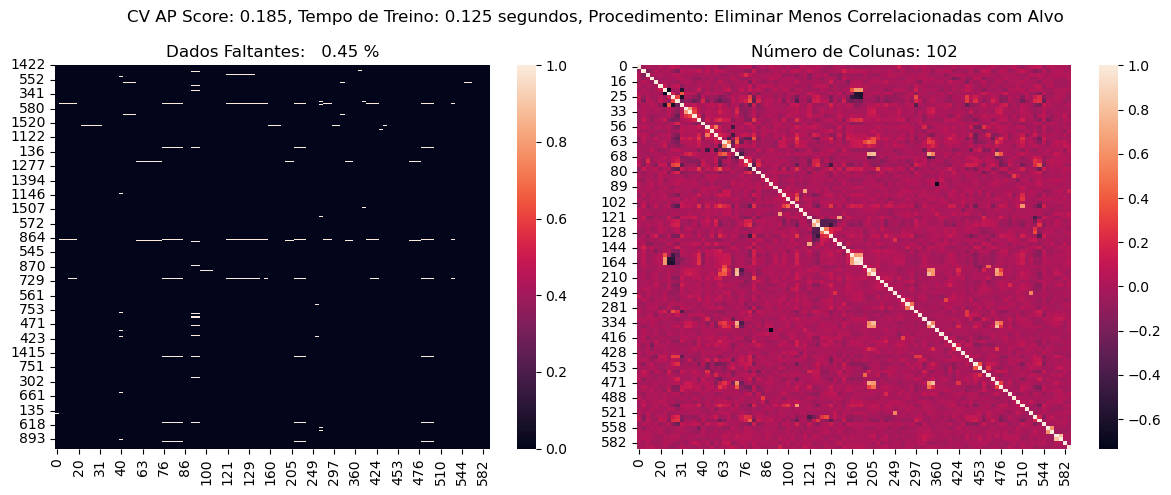

In [19]:
X_copy = pearson_drop(X_copy, y_train, 0.025)

records = info_resume(X_copy, 'Eliminar Menos Correlacionadas com Alvo', records)

Observamos melhorias significativas na velocidade e no desempenho geral, com um aprimoramento de aproximadamente 50%. Isso sugere que os recursos menos correlacionados estavam contribuindo com ruído para o modelo.

### 3.2. Recursive Feature Elimination

Recursive Feature Elimination (RFE) é uma técnica de seleção de características que visa identificar as características mais importantes em um conjunto de dados. Ele funciona eliminando recursivamente os recursos do conjunto de dados com base em sua importância ou relevância para a variável de destino. A importância é selecionada por coeficientes de Regressão Logística. O processo teve que ser feito manualmente, já que o RFE do scikit-learn [não funciona bem com dados ausentes](https://github.com/scikit-learn/scikit-learn/issues/21743).

In [20]:
def recursive_feature_elimination(X, y, kf, verbose = False):
    
    model = pipe_lr.fit(X, y)
    coefs = model.named_steps['estimator'].coef_
    args = np.argsort(np.abs(coefs))
    ord_feats = np.array(X.columns)[args][0]
    X = X.loc[:, ord_feats]
    
    cv_mean = []
    cv_std = []
    
    for i in range(len(X.columns) - 1):
        
        cv_score = cross_val_score(pipe_lr, X, y, cv = kf, scoring = 'average_precision')
        cv_mean.append(cv_score.mean())
        cv_std.append(cv_score.std())
        
        X = X.iloc[:, 1:]
        
        if verbose:
            print(f'Features Evaluated: {i:2d}, score: {cv_score.mean():.3f}')
    
    return np.array(cv_mean[::-1]), np.array(cv_std[::-1]), ord_feats[::-1]

cv_mean, cv_std, ord_feats = recursive_feature_elimination(X_copy, y_train, kf, True)

Features Evaluated:  0, score: 0.185
Features Evaluated:  1, score: 0.185
Features Evaluated:  2, score: 0.186
Features Evaluated:  3, score: 0.185
Features Evaluated:  4, score: 0.187
Features Evaluated:  5, score: 0.192
Features Evaluated:  6, score: 0.192
Features Evaluated:  7, score: 0.188
Features Evaluated:  8, score: 0.196
Features Evaluated:  9, score: 0.194
Features Evaluated: 10, score: 0.194
Features Evaluated: 11, score: 0.193
Features Evaluated: 12, score: 0.196
Features Evaluated: 13, score: 0.197
Features Evaluated: 14, score: 0.197
Features Evaluated: 15, score: 0.198
Features Evaluated: 16, score: 0.199
Features Evaluated: 17, score: 0.200
Features Evaluated: 18, score: 0.202
Features Evaluated: 19, score: 0.205
Features Evaluated: 20, score: 0.212
Features Evaluated: 21, score: 0.209
Features Evaluated: 22, score: 0.211
Features Evaluated: 23, score: 0.215
Features Evaluated: 24, score: 0.211
Features Evaluated: 25, score: 0.203
Features Evaluated: 26, score: 0.202
F

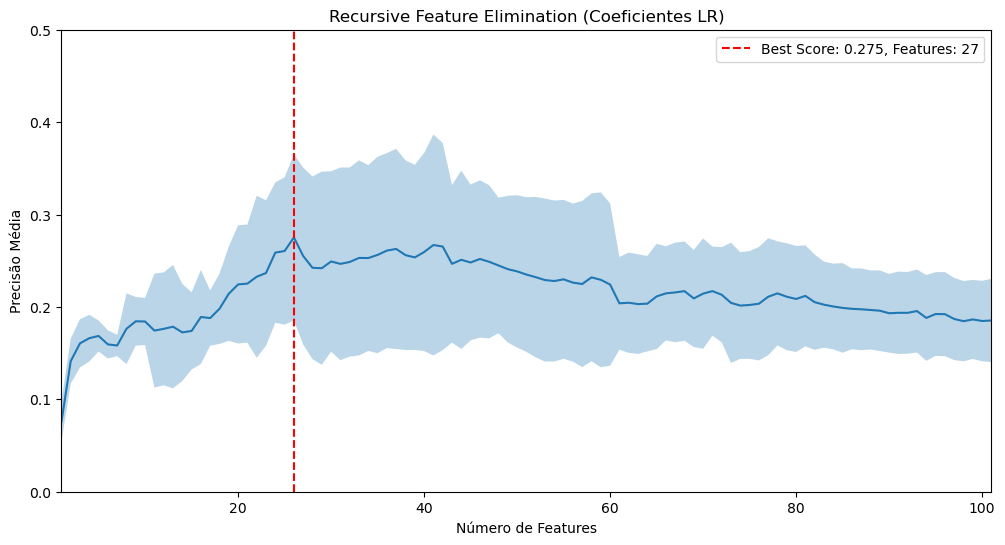

In [21]:
arg = np.argmax(cv_mean)
max_ap = np.max(cv_mean)

fig, ax = plt.subplots(1, 1, figsize = (12, 6))
ax.plot(range(1, len(ord_feats)), cv_mean)
ax.fill_between(range(1, len(ord_feats)), cv_mean - cv_std, cv_mean + cv_std, alpha = 0.3)
ax.set_xlim(1, 101)
ax.set_ylim(0, 0.5)
ax.axvline(arg+1, ls = '--', color = 'r', label = f'Best Score: {max_ap:.3f}, Features: {arg+2}')
ax.set_ylabel('Precisão Média')
ax.set_xlabel('Número de Features')
ax.grid(False)
ax.set_title('Recursive Feature Elimination (Coeficientes LR)')
ax.legend();

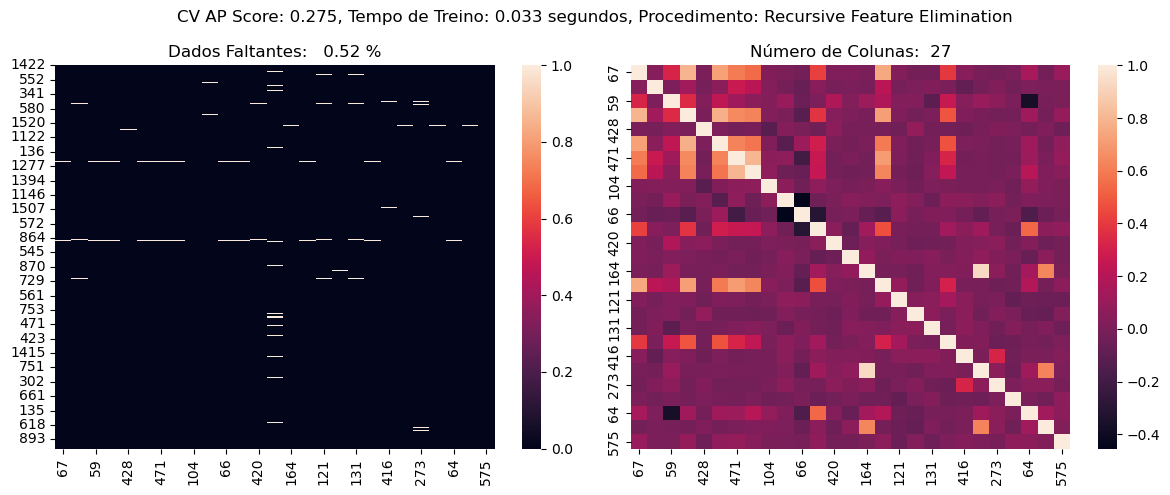

In [22]:
X_copy = X_train.loc[:, ord_feats[:arg+2]]

records = info_resume(X_copy, 'Recursive Feature Elimination', records);

Há forte aumento no desempenho geral e diminuição no tempo de treinamento, pois agora, informado pelo alvo, foram selecionadas as melhores features

## 4. Otimização de Hiperparâmetros

O próximo passo é otimizar os hiperparâmetros que foram inicialmente definidos antes do processo de seleção de recursos. Para conseguir isso, empregamos uma abordagem de busca aleatória para explorar a melhor combinação de hiperparâmetros. Especificamente, nos concentramos em ajustar os parâmetros C, o peso da classe e o número de vizinhos.

In [23]:
selected_feats = X_copy.columns

X_train = X_train.loc[:, selected_feats]
X_test = X_test.loc[:, selected_feats]


p_dist1 = {'estimator__C': np.logspace(-1, 2, 100),
          'imputer__n_neighbors': np.linspace(15, 50, 20, dtype = int),
          'estimator__class_weight': [{0: 1, 1: w} for w in np.linspace(10, 60, 100)]
         }

search1 = RandomizedSearchCV(pipe_lr, p_dist1, n_iter = 400, cv = kf, verbose=False, scoring = 'average_precision')

In [24]:
search1.fit(X_train, y_train);

In [25]:
df_cv_results1 = pd.DataFrame(search1.cv_results_)

df_cv_results1['class_weight'] = df_cv_results1['param_estimator__class_weight'].apply(lambda x: x[1])

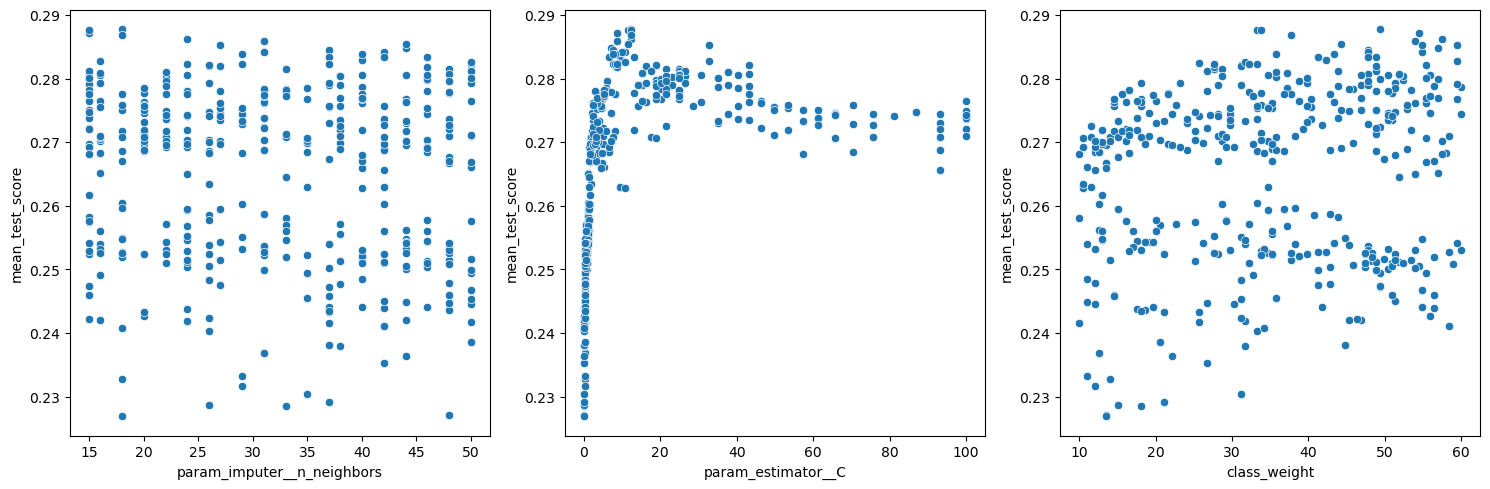

In [26]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

sns.scatterplot(data = df_cv_results1, 
                x = 'param_imputer__n_neighbors', 
                y = 'mean_test_score', ax = ax[0])
sns.scatterplot(data = df_cv_results1,
                x = 'param_estimator__C',
                y = 'mean_test_score', ax = ax[1])
sns.scatterplot(data = df_cv_results1,
                x = 'class_weight',
                y = 'mean_test_score', ax = ax[2])

fig.tight_layout()

In [27]:
best = search1.best_params_

best

{'imputer__n_neighbors': 18,
 'estimator__class_weight': {0: 1, 1: 49.3939393939394},
 'estimator__C': 12.32846739442066}

Observando-se os diagramas de dispersão, vê-se que o número de vizinhos não tem um impacto muito signnificativo, possuindo seus maiores resultados na validação em valore abaixo de 27. Já no parâmetro C, observa-se claramente uma convergência para valores em torno de 10, reduzindo a performance a medida em que se aumenta C. Para o peso de classe, observa-se uma tendência de aumento da performance até se estabilizar após o valor 40.

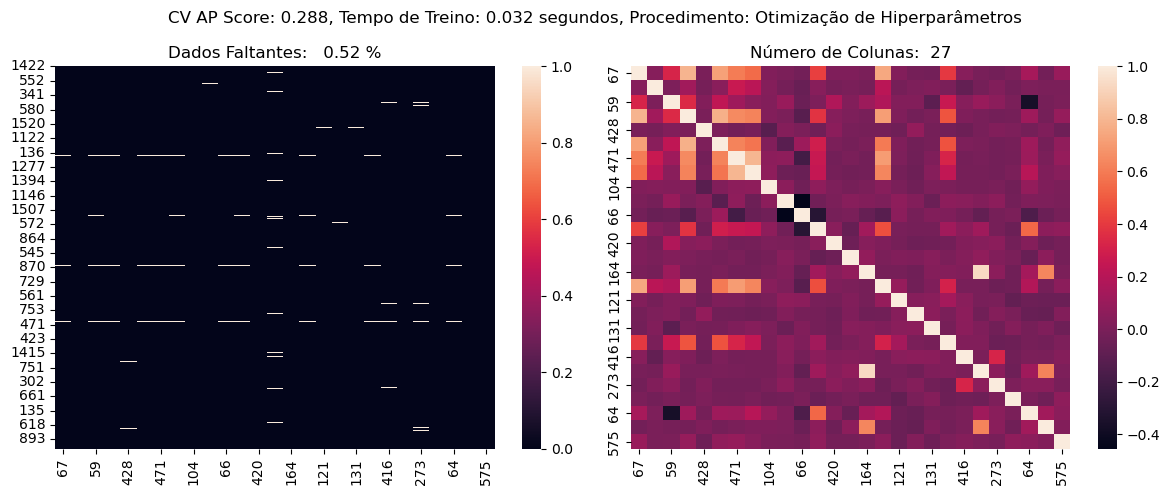

In [28]:
pipe_lr = Pipeline(steps = [
    ('scaler', MinMaxScaler()),
    ('imputer', KNNImputer(n_neighbors = best['imputer__n_neighbors'])),
    ('estimator', LogisticRegression(penalty = 'l2', 
                                     solver = 'liblinear', 
                                     max_iter = int(1e5),
                                     C = best['estimator__C'],
                                     class_weight = best['estimator__class_weight']))
])

records = info_resume(X_train, 'Otimização de Hiperparâmetros', records)

Houve uma leve queda no tempo de treino e um aumento notável na performance, mas não tanto quanto as técnicas de seleção de features.

## 5. Model Evaluation

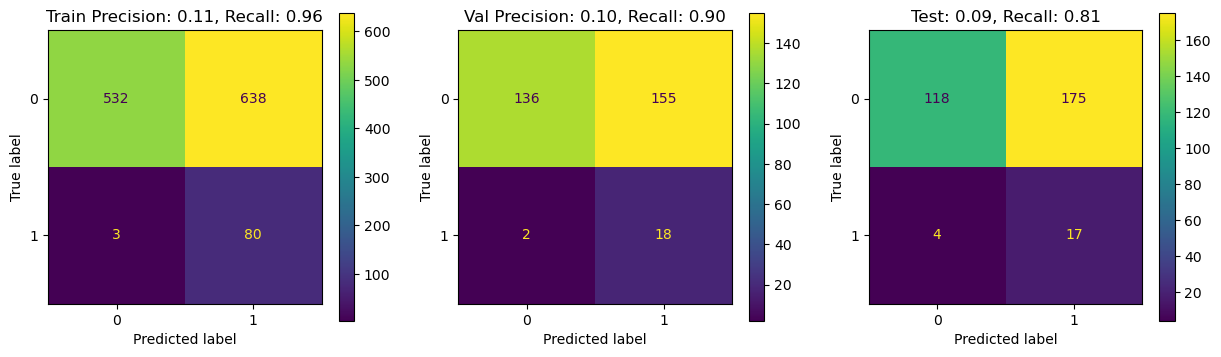

In [29]:
cm_val = 0

for train_index, val_index in kf.split(X_train, y_train):
    
    X_par_train, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
    y_par_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index] 
    
    pipe_lr.fit(X_par_train, y_par_train)
    y_pred_val = pipe_lr.predict(X_val)

    cm_val += cm(y_val, y_pred_val)
    
pipe_lr.fit(X_train, y_train)

y_pred = pipe_lr.predict(X_test)
y_pred_train = pipe_lr.predict(X_train)

cm_test = cm(y_test, y_pred)
cm_train = cm(y_train, y_pred_train)
    
cm_val //= 4

val_precision = cm_val[1, 1] / (cm_val[1, 1] + cm_val[0, 1]) 
train_precision = cm_train[1, 1] / (cm_train[1, 1] + cm_train[0, 1])
test_precision = cm_test[1, 1] / (cm_test[1, 1] + cm_test[0, 1])

val_recall = cm_val[1, 1] / (cm_val[1, 1] + cm_val[1, 0]) 
train_recall = cm_train[1, 1] / (cm_train[1, 1] + cm_train[1, 0])
test_recall = cm_test[1, 1] / (cm_test[1, 1] + cm_test[1, 0])

fig, ax = plt.subplots(1, 3, figsize = (15, 4))

plot1 = ConfusionMatrixDisplay(cm_train)
plot2 = ConfusionMatrixDisplay(cm_val)
plot3 = ConfusionMatrixDisplay(cm_test)

plot1.plot(ax = ax[0]) 
plot2.plot(ax = ax[1])
plot3.plot(ax = ax[2]);

ax[0].set_title(f'Train Precision: {train_precision:.2f}, Recall: {train_recall:.2f}')
ax[1].set_title(f'Val Precision: {val_precision:.2f}, Recall: {val_recall:.2f}')
ax[2].set_title(f'Test: {test_precision:.2f}, Recall: {test_recall:.2f}');

Podemos ver que o desbalanceamento está afetando a performance do modelo. Tem-se uma quantidade considerável de alarmes falsos que proporcionalmente é muito superior ao número de verdadeiros positivos, ocorrendo uma baixa precisão. Entretando, temos uma boa sensitividade, com muito poucos falsos negativos. No contexto de detecção de falhas, falsos negativos são mais prejudiciais, uma vez que está se deixando falhas passarem, podendo incorrer eventos catastróficos.  Os valores da validação e do teste estão próximos, levando a conclusão que o processo de validação aplicado é bem representativo para valores não vistos. Porém, vale ressaltar que essas classificações estão definidas por um threshold de 0,5. 

In [30]:
val_scores = []
val_labels = []

for train_index, val_index in kf.split(X_train, y_train):
    
    X_par_train, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
    y_par_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    pipe_lr.fit(X_par_train, y_par_train)
    val_score = pipe_lr.predict_proba(X_val)[:, 1]
    
    val_scores.append(val_score)
    val_labels.append(y_val)
    
pipe_lr.fit(X_train, y_train)

test_scores = pipe_lr.predict_proba(X_test)[:, 1]
train_scores = pipe_lr.predict_proba(X_train)[:, 1]
    
val_scores = np.concatenate(val_scores)
val_labels = np.concatenate(val_labels)

fpr_train, tpr_train, _ = roc_curve(y_train, train_scores)
fpr_val, tpr_val, _ = roc_curve(val_labels, val_scores)
fpr_test, tpr_test, _ = roc_curve(y_test, test_scores)

pre_train, rec_train, _ = precision_recall_curve(y_train, train_scores)
pre_val, rec_val, _ = precision_recall_curve(val_labels, val_scores)
pre_test, rec_test, _ = precision_recall_curve(y_test, test_scores)

auc_train = roc_auc_score(y_train, train_scores)
ap_train = average_precision_score(y_train, train_scores)

auc_val = cross_val_score(pipe_lr, X_train, y_train, cv = kf, scoring = 'roc_auc').mean()
ap_val = cross_val_score(pipe_lr, X_train, y_train, cv = kf, scoring = 'average_precision').mean()

auc_test = roc_auc_score(y_test, test_scores)
ap_test = average_precision_score(y_test, test_scores)


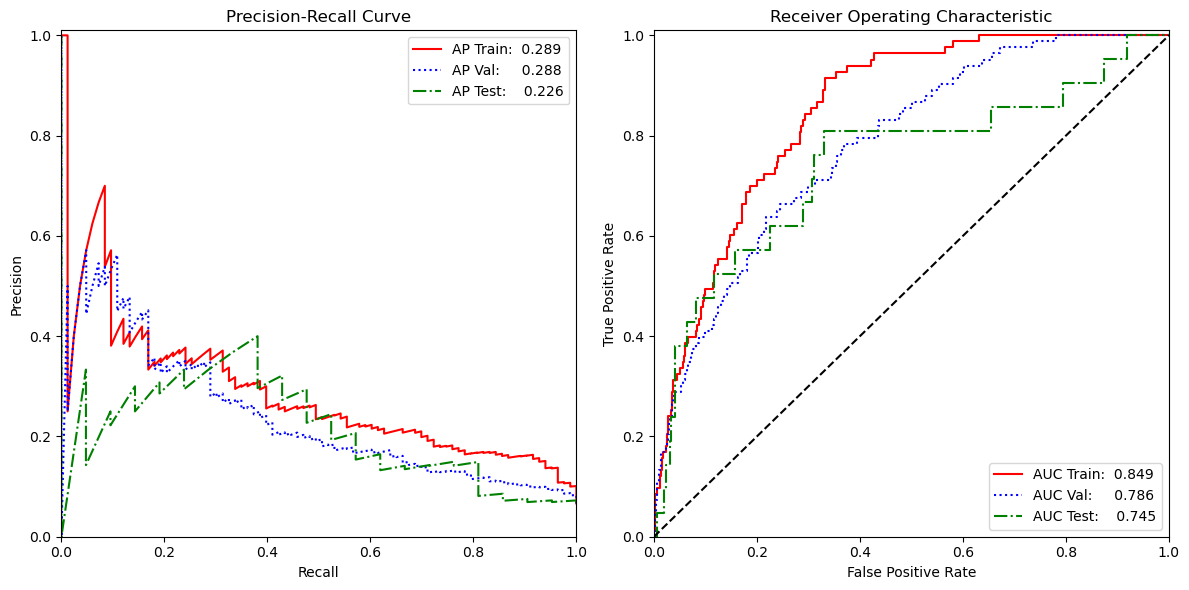

In [31]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))


ax[0].plot(rec_train, pre_train, label = f'AP Train:{ap_train:7.3f}', ls = '-', color = 'r')
ax[0].plot(rec_val, pre_val, label = f'AP Val:   {ap_val:7.3f}', ls = ':', color = 'b')
ax[0].plot(rec_test, pre_test, label = f'AP Test:  {ap_test:7.3f}', ls = '-.', color = 'g')
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1.01)
ax[0].legend()
ax[0].set_title('Precision-Recall Curve')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')

ax[1].plot(fpr_train, tpr_train, label = f'AUC Train:{auc_train:7.3f}', ls = '-', color = 'r')
ax[1].plot(fpr_val, tpr_val, label = f'AUC Val:   {auc_val:7.3f}', ls = ':', color = 'b')
ax[1].plot(fpr_test, tpr_test, label = f'AUC Test:  {auc_test:7.3f}', ls = '-.', color = 'g')
ax[1].plot([0, 1], [0, 1], ls = '--', color = 'k')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1.01)
ax[1].legend()
ax[1].set_title('Receiver Operating Characteristic')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate');

fig.tight_layout()

Ao analisar as curvas de precisão média e ROC para cada conjunto de dados, observamos algo importante. É evidente que a curva ROC pode nos dar uma impressão equivocada de um desempenho excelente, especialmente quando lidamos com dados desbalanceados. Isso ocorre porque a presença significativa de falsos positivos diminui a precisão geral do modelo, tornando necessário considerar outras métricas, como a precisão média, que leva em conta a distribuição das classes e oferece uma visão mais precisa do desempenho em problemas desbalanceados.

* [The Relationship Between Precision-Recall and ROC Curves](https://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf)
* [ROC vs Precision-recall curves on imbalanced dataset](https://stats.stackexchange.com/questions/262616/roc-vs-precision-recall-curves-on-imbalanced-dataset)
* [ROC Curves and Precision-Recall Curves for Imbalanced Classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)

## 5. Conclusão

Text(0, 0.5, 'Tempo de Treino [seconds]')

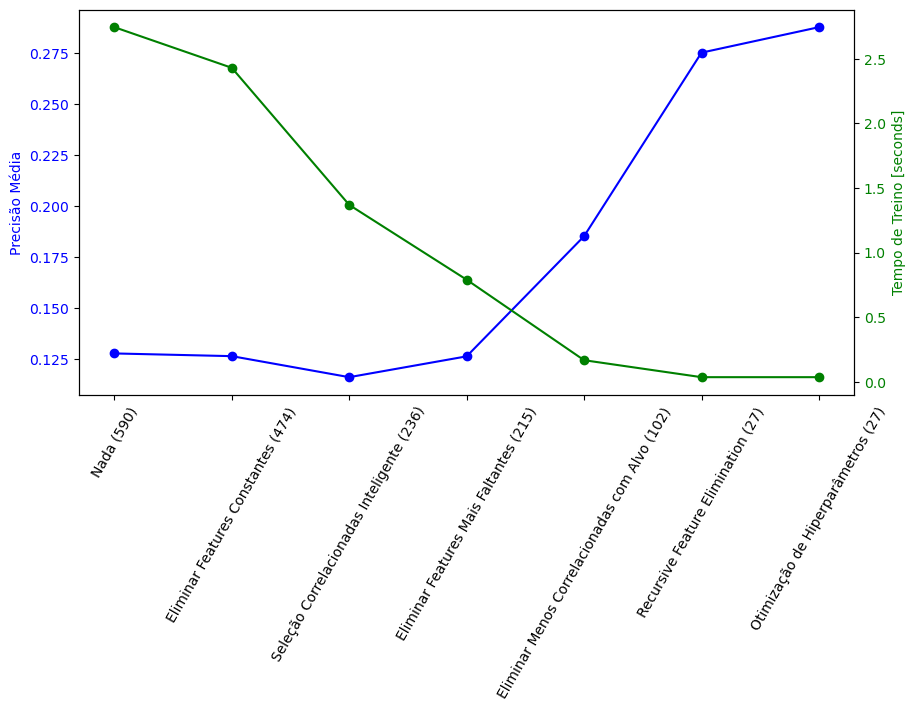

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))

ax.plot(records['procedure'], records['cv_ap_score'], marker = 'o', color = 'b')
ax.tick_params(axis='x', labelrotation=60)
ax.tick_params(axis='y', labelcolor='b')
ax.set_ylabel('Precisão Média', color='b')

ax2 = ax.twinx()

ax2.plot(records['procedure'], records['training_time'], marker = 'o', color = 'g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_ylabel('Tempo de Treino [seconds]', color='g') 

Ao analisar as curvas, podemos observar que não há um aumento significativo no desempenho do modelo ao aplicar métodos de seleção de features não supervisionados. Na verdade, a eliminação de características correlacionadas pode até resultar em uma queda no desempenho. No entanto, há uma redução significativa no tempo de treinamento, o que acelera os métodos supervisionados de seleção de features, especialmente em conjuntos de dados de grande dimensão como o presente. O maior ganho de desempenho foi obtido com a aplicação da Recursive Feature Elimination (RFE), superando até mesmo o processo de otimização de hiperparâmetros. Isso nos leva à conclusão de que o pré-processamento é indispensável em aplicações de Aprendizado de Máquina, destacando a importância da seleção adequada de features para alcançar resultados ótimos.

In [33]:
with open('features_selected.txt', 'w') as f:
    for c in X_train.columns:
        f.write(str(c))